# Predict the number of upvotes for a post 

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix, mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error

In [56]:
glove_columns = ['glove_{0}'.format(j) for j in range(50)]
other_columns = ['up_votes','time_created','day_of_the_week', 'nsfw', 'author_mean', 'author_std', 'title_length']

column_labels = other_columns+glove_columns

In [2]:
data = np.load('feature_data.npy')

In [3]:
X = data[:,1:]
y = data[:,0]

In [47]:
# we will also split the data into 5 different classes based on number of upvotes to try to classify
choices = [0,1,2,3,4]
conditions=[y<=5,y<=25,y<=100,y<=750,y>750]
labels = np.select(conditions, choices)

In [149]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(X, y,labels, test_size = 0.1, random_state = 42)


## Regression models 

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [254]:
def model_diagnostics(model, X_test, y_test):
    y_predicted = model.predict(X_test)
    
    r2 = r2_score(y_test, y_predicted)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_predicted)
    msle=0
#     msle = np.sqrt(mean_squared_log_error(y_test, y_predicted))
    
    print(f"R2: {r2:.4}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print(f"MSLE: {msle}")
    
    return [r2, rmse, mape, msle ]

def model_comparison(model_performance_dict, metric = 'rmse'):

    model_names = model_performance_dict.keys()
    
    metrics = ['r2', 'rmse', 'mape', 'msle']
    index = metrics.index(metric)
    
    metric_values = [model_performance_dict[model][index] for model in model_names ]
    sorted_pairs = sorted(zip(model_names, metric_values), key = lambda t: t[1], reverse=True)

    fig, ax = plt.subplots(figsize = (12,6))

    ax.bar([pair[0] for pair in sorted_pairs], [pair[1] for pair in sorted_pairs])
    plt.title(metric)
    plt.xlabel('Model')
    plt.xticks(rotation = 45)
    plt.ylabel(metric)
    plt.show()

### predict number of upvotes 

In [7]:
# Instantiate and train models
baseline = DummyRegressor(strategy='mean').fit(X_train,y_train)
linear = LinearRegression().fit(X_train, y_train)
lasso = LassoCV().fit(X_train, y_train)
# ridge = RidgeCV().fit(X_train, y_train)
elastic = ElasticNetCV().fit(X_train, y_train)
kn = KNeighborsRegressor().fit(X_train, y_train)
rf = RandomForestRegressor(n_jobs = 4, random_state = 42).fit(X_train, y_train)
gradient = GradientBoostingRegressor(random_state = 42).fit(X_train, y_train)

In [246]:
models = [baseline, linear, lasso, elastic, kn, rf, gradient]
model_names = ['baseline', 'linear', 'lasso', 'elastic', 'kn', 'rf', 'gradient']
model_performance_dict = {model_name : model_diagnostics(model, X_test, y_test) for model_name, model in zip(model_names, models)}

R2: -1.275e-06
RMSE: 530.2328892540529
MAPE: 8.855019417470709e+16
MSLE: 0
R2: 0.1389
RMSE: 492.036559921396
MAPE: 6.806204409361941e+16
MSLE: 0
R2: 0.008554
RMSE: 527.9599964675112
MAPE: 8.045067318496427e+16
MSLE: 0
R2: 0.008554
RMSE: 527.9599964674417
MAPE: 8.045067318247347e+16
MSLE: 0
R2: -0.1011
RMSE: 556.3874045971637
MAPE: 5.964016697365338e+16
MSLE: 0
R2: 0.1087
RMSE: 500.59459073883335
MAPE: 6.8188446612482504e+16
MSLE: 0
R2: 0.1468
RMSE: 489.7667266995807
MAPE: 5.519282186314142e+16
MSLE: 0


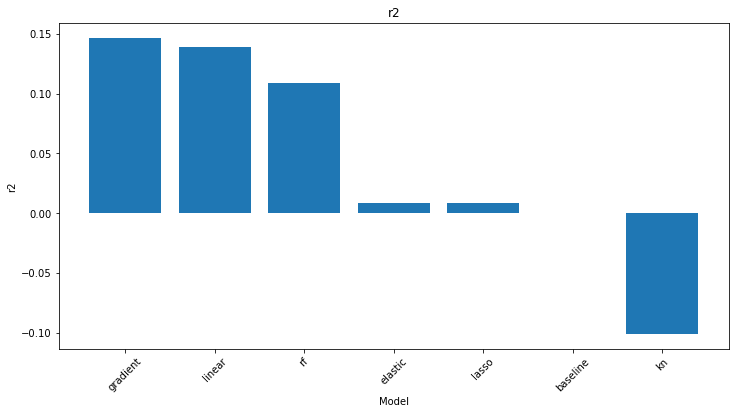

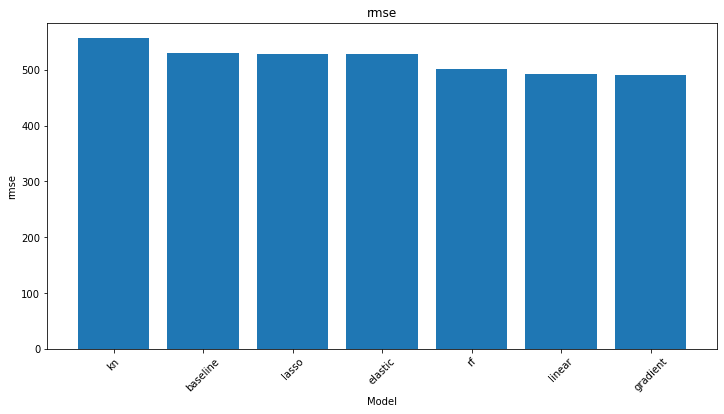

In [272]:
model_comparison(model_performance_dict, metric = 'r2')
model_comparison(model_performance_dict, metric = 'rmse')

none of the models performs particularly well.

### check residuals 

In [261]:
residuals_lists = [[y_test - model.predict(X_test)] for model in models]


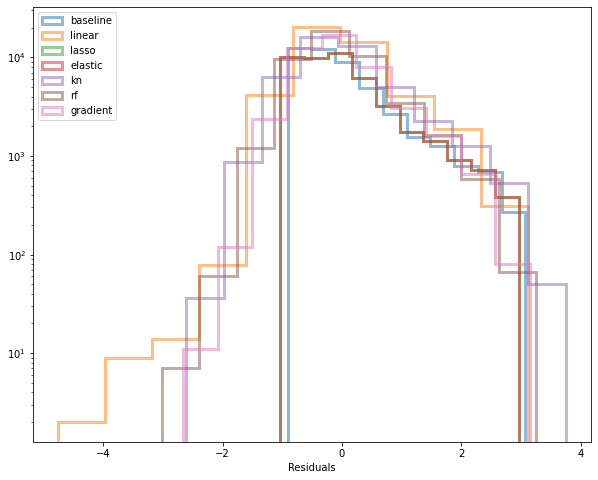

In [278]:
plt.figure(figsize=[10,8])
for residuals, model_name in zip(residuals_lists, model_names):
    plt.hist(residuals, alpha=0.5, label=model_name, histtype='step', linewidth=3)
plt.semilogy()
plt.legend()
plt.xlabel('Residuals')
plt.show()

There is a very wide range of upvote values possible, with an imbalanced distribution. Perhaps if instead we try to predict the log of the upvotes +1 it will be an easier task for the models.

### predict log number of upvotes +1 

In [240]:
y_train_log = np.log10(y_train+1)

baseline_log = DummyRegressor(strategy='mean').fit(X_train,y_train_log)
linear_log = LinearRegression().fit(X_train, y_train_log)
lasso_log = LassoCV().fit(X_train, y_train_log)
elastic_log = ElasticNetCV().fit(X_train, y_train_log)
kn_log = KNeighborsRegressor().fit(X_train, y_train_log)
rf_log = RandomForestRegressor(n_jobs = 4, random_state = 42).fit(X_train, y_train_log)
gradient_log = GradientBoostingRegressor(random_state = 42).fit(X_train, y_train_log)

In [248]:
y_test_log = np.log10(y_test+1)

models_log = [baseline_log, linear_log, lasso_log, elastic_log, kn_log, rf_log, gradient_log]
log_model_performance_dict = {model_name : model_diagnostics(model, X_test, y_test_log) for model_name, model in zip(model_names, models_log)}

R2: -2.478e-06
RMSE: 0.7900093096786931
MAPE: 725936371333942.8
MSLE: 0
R2: 0.1401
RMSE: 0.7325833129474741
MAPE: 649386385342806.9
MSLE: 0
R2: 0.01223
RMSE: 0.7851627931442763
MAPE: 708838579299670.6
MSLE: 0
R2: 0.01223
RMSE: 0.7851627931442747
MAPE: 708838579299694.1
MSLE: 0
R2: -0.07944
RMSE: 0.8207864410131714
MAPE: 622299933859861.1
MSLE: 0
R2: 0.203
RMSE: 0.705273352969173
MAPE: 596278038196939.4
MSLE: 0
R2: 0.2008
RMSE: 0.7062299621805922
MAPE: 604855249985995.0
MSLE: 0


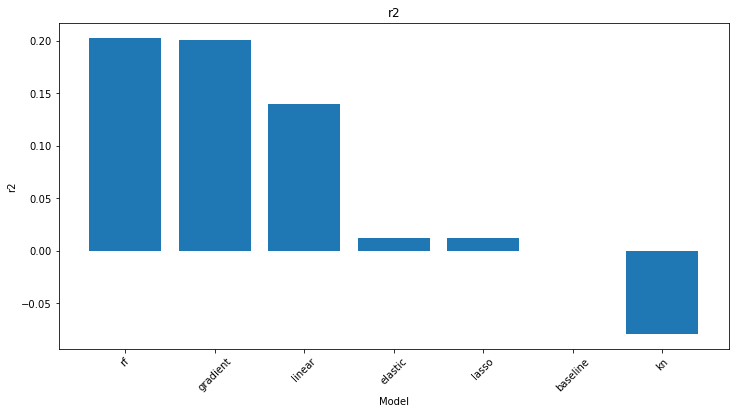

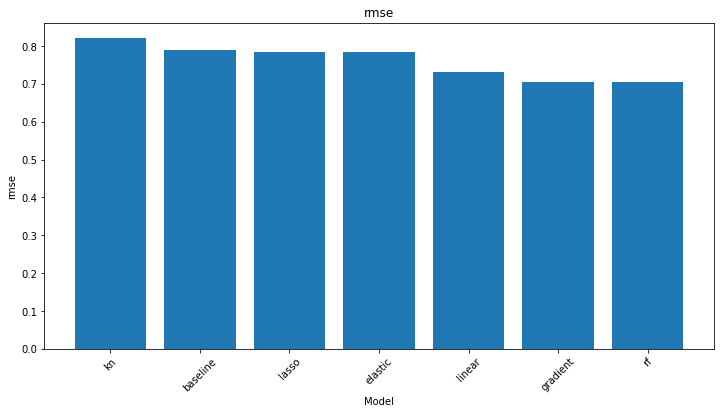

In [273]:
model_comparison(log_model_performance_dict, metric = 'r2')
model_comparison(log_model_performance_dict, metric = 'rmse')


Compared to the R^2 value for the number of upvotes, the Random Forest and Gradient Boosting Regressor seem to find a better fit when trying to predict the log of the upvotes.

In [274]:
log_residuals_lists = [[y_test_log - model.predict(X_test)] for model in models_log]

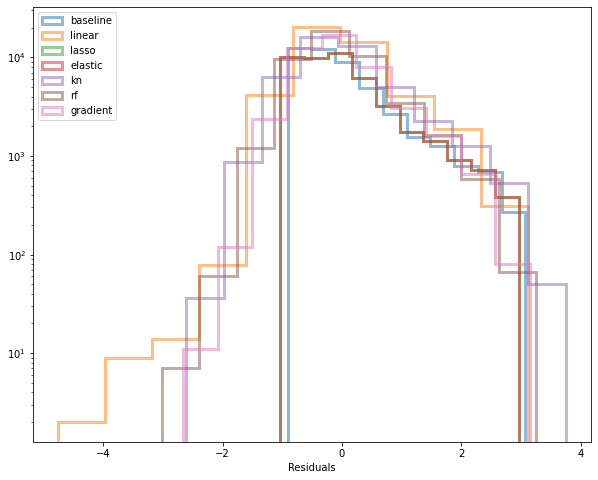

In [277]:
plt.figure(figsize=[10,8])
for residuals, model_name in zip(log_residuals_lists, model_names):
    plt.hist(residuals, alpha=0.5, label=model_name, histtype='step', linewidth=3)
plt.semilogy()
plt.legend()
plt.xlabel('Residuals')
plt.show()

None of these models perform particularly well. Let's attempt a simpler problem of classifying a post within a range of upvotes.

## Classification 

In [284]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


## divide into 5 ranges 

First we will divide the data into 5 classes based on the number of upvotes. These classes were arbitrarily selected arbitrarily to roughly correspond to increasing orders of magnitude (y<=5,y<=25,y<=100,y<=750,y>750). It is important to note that these classes are extremely imbalanced and over half of the samples are in the first class.

In [280]:
#train models
kn_clf = KNeighborsClassifier(n_jobs = 4).fit(X_train, labels_train)
lr = LogisticRegression().fit(X_train, labels_train)
rf_clf = RandomForestClassifier(n_jobs = 4, random_state = 42).fit(X_train, labels_train)
gb_clf = GradientBoostingClassifier(random_state = 42).fit(X_train, labels_train)

clf_models = [kn_clf, lr, rf_clf, gb_clf]

KNeighborsClassifier(n_jobs=4)


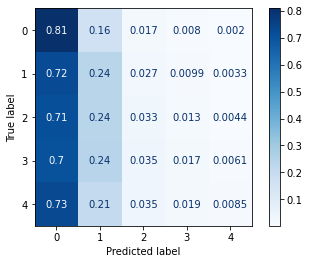

LogisticRegression(multi_class='multinomial')


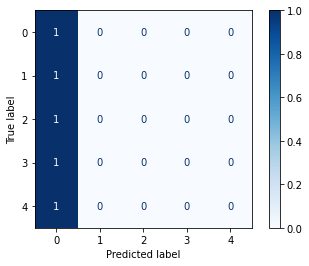

RandomForestClassifier(n_jobs=4, random_state=42)


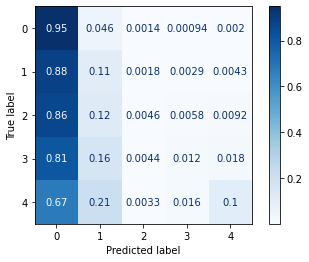

GradientBoostingClassifier(random_state=42)


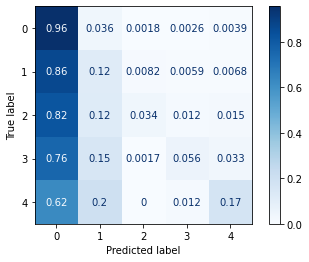

In [310]:
for model in clf_models:
    print(model)
    plot_confusion_matrix(model, X_test, labels_test,
                                 display_labels=[0,1,2,3,4],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.show()

All the models perform pretty well in classifying low upvote (class 0) posts, but very poorly for all other classes. In fact most objects are classified to be class 0, probably because of the heavy bias towards first group in the training sample.

We can simplify the problem even further by having only 2 classes

### divide into 2 classes 

If we split the samples at the 5 upvote mark, then we roughly have 2 equally sized subsamples. Though they may not be uniformly distinct along the features.

##### greater than 5 upvotes 

In [318]:
# assign new label 
popular_labels = np.array(y > 5)*1

In [343]:
print('{0} of samples have > 5 upvotes'.format(round(np.sum(popular_labels)/len(popular_labels),2)))

0.46 of samples have > 5 upvotes


In [319]:
# Split the data into training and testing sets. The split is the same as before, we are just splitting the popular labels as well now.
X_train, X_test, y_train, y_test, labels_train, labels_test, popular_labels_train, popular_labels_test = train_test_split(X, y,labels, popular_labels, test_size = 0.1, random_state = 42)


In [321]:
#train models
popular_kn_clf = KNeighborsClassifier(n_jobs = 4).fit(X_train, popular_labels_train)
popular_lr = LogisticRegression().fit(X_train, popular_labels_train)
popular_rf_clf = RandomForestClassifier(n_jobs = 4, random_state = 42).fit(X_train, popular_labels_train)
popular_gb_clf = GradientBoostingClassifier(random_state = 42).fit(X_train, popular_labels_train)

popular_clf_models = [popular_kn_clf, popular_lr, popular_rf_clf, popular_gb_clf]

KNeighborsClassifier(n_jobs=4)


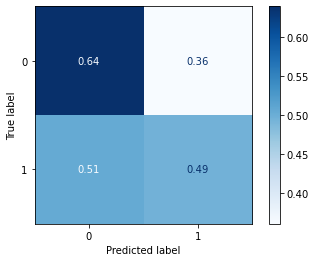

LogisticRegression()


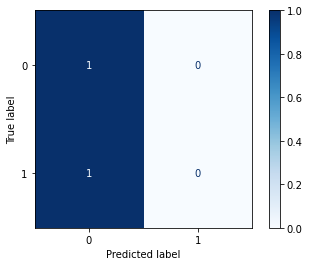

RandomForestClassifier(n_jobs=4, random_state=42)


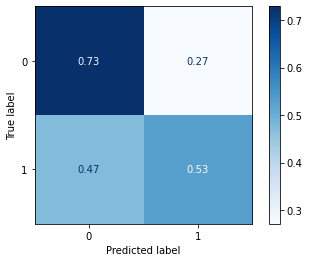

GradientBoostingClassifier(random_state=42)


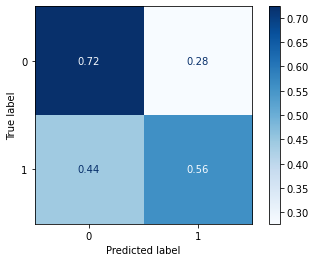

In [322]:
for model in popular_clf_models:
    print(model)
    plot_confusion_matrix(model, X_test, popular_labels_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.show()

There is a significant increase in accuracy for class 1 objects, though it is only slightly better than chance. There is also an important decrease in accuracy for class 0 objects.

### check distribution of upvotes in each class for best performing model

In [327]:
gb_predictions = popular_gb_clf.predict(X_test)

In [330]:
popular_prediction_mask = gb_predictions == 1

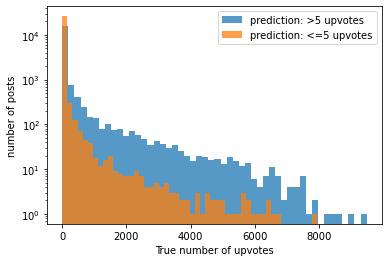

In [337]:
plt.hist(y_test[popular_prediction_mask], bins=50, alpha=0.75, label='prediction: >5 upvotes')
plt.hist(y_test[~popular_prediction_mask], bins=50, alpha=0.75, label='prediction: <=5 upvotes')
plt.semilogy()
plt.xlabel('True number of upvotes')
plt.ylabel('number of posts')
plt.legend()
plt.show()

There are few posts with very high upvotes (> ~1000) that are misclassified as being of few upvotes. This suggests that it may be easier to discriminate very popular posts from not very popular posts.

Now let's try splitting at the 1000 upvote mark. This will result in much more unbalanced subsamples.

##### greater than 1000 upvotes 

In [338]:
very_popular_labels = np.array(y > 1000)*1

In [346]:
print('{0} of samples have > 1000 upvotes'.format(round(np.sum(very_popular_labels)/len(very_popular_labels),2)))
print('{0} samples have > 1000 upvotes'.format(np.sum(very_popular_labels)))
print('{0} samples have <= 1000 upvotes'.format(len(very_popular_labels) - np.sum(very_popular_labels)))

0.03 of samples have > 1000 upvotes
12889 samples have > 1000 upvotes
441647 samples have <= 1000 upvotes


In [339]:
# Split the data into training and testing sets. Again the same split as before
X_train, X_test, y_train, y_test, labels_train, labels_test, very_popular_labels_train, very_popular_labels_test = train_test_split(X, y,labels, very_popular_labels, test_size = 0.1, random_state = 42)


In [340]:
#train only top 2 performing models
very_popular_rf_clf = RandomForestClassifier(n_jobs = 4, random_state = 42).fit(X_train, very_popular_labels_train)
very_popular_gb_clf = GradientBoostingClassifier(random_state = 42).fit(X_train, very_popular_labels_train)

very_popular_clf_models = [very_popular_rf_clf, very_popular_gb_clf]

KNeighborsClassifier(n_jobs=4)


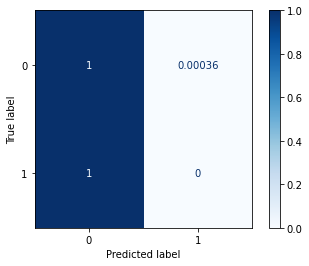

LogisticRegression()


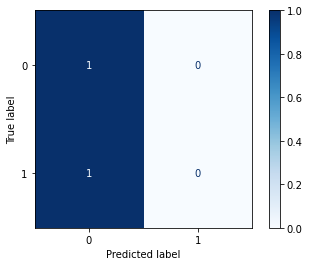

RandomForestClassifier(n_jobs=4, random_state=42)


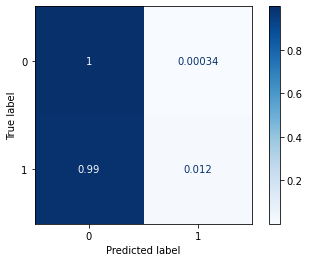

GradientBoostingClassifier(random_state=42)


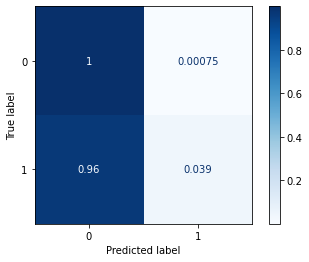

In [341]:
for model in very_popular_clf_models:
    print(model)
    plot_confusion_matrix(model, X_test, very_popular_labels_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.show()

Unsurprisingly, the extreme inbalance in the subsamples results in virtually all samples predicted to be of class 0.

#### Let's resample training set to have a more balanced sample.  

In [370]:
from sklearn.utils import resample

# concatenate X and y to recreate training set
training_set = np.concatenate((X_train, very_popular_labels_train[:,None]), axis=1)

# separate classes
popular = training_set[very_popular_labels_train == 1]
not_popular = training_set[very_popular_labels_train == 0]

In [388]:
# undersample the not popular posts
undersample = resample(not_popular, 
                       replace=False, 
                       n_samples=2*len(popular), #twice as many sample as in popular class
                       random_state=42)

# create new training set. 1:2 ratio of popular:unpopular
undersample_train = np.concatenate((popular, undersample))

# separate into X and y sets
undersample_x_train = undersample_train[:,:-1]
undersample_y_train = undersample_train[:,-1]


In [389]:
#train models on resampled training set
undersample_very_popular_rf_clf = RandomForestClassifier(n_jobs = 4, random_state = 42).fit(undersample_x_train, undersample_y_train)
undersample_very_popular_gb_clf = GradientBoostingClassifier(random_state = 42).fit(undersample_x_train, undersample_y_train)

undersample_very_popular_clf_models = [undersample_very_popular_rf_clf, undersample_very_popular_gb_clf]


RandomForestClassifier(n_jobs=4, random_state=42)


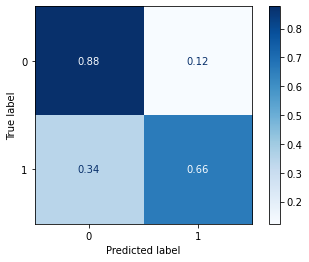

GradientBoostingClassifier(random_state=42)


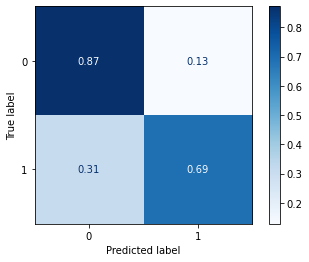

In [390]:
for model in undersample_very_popular_clf_models:
    print(model)
    plot_confusion_matrix(model, X_test, very_popular_labels_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.show()

These models perform much better now. Over 2/3 of popular posts are correctly labeled and almost 90% of non-popular posts are also accurately labeled.

### Let's also try oversampling  popular posts in the training set

In [406]:
# oversample the popular posts
oversample = resample(popular, 
                       replace=True, 
                       n_samples=int(1.5*len(popular)), #add 50% more popular samples
                       random_state=42)

# create new training set. It is now much more balanced with a 3:4 ratio of popular:unpopular posts
resample_train = np.concatenate((oversample, undersample))

# separate into X and y sets
resample_x_train = resample_train[:,:-1]
resample_y_train = resample_train[:,-1]


In [407]:
#train models on resampled training set
resample_very_popular_rf_clf = RandomForestClassifier(n_jobs = 4, random_state = 42).fit(resample_x_train, resample_y_train)
resample_very_popular_gb_clf = GradientBoostingClassifier(random_state = 42).fit(resample_x_train, resample_y_train)

resample_very_popular_clf_models = [resample_very_popular_rf_clf, resample_very_popular_gb_clf]


RandomForestClassifier(n_jobs=4, random_state=42)


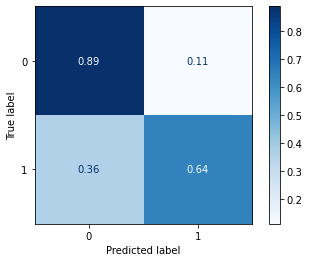

GradientBoostingClassifier(random_state=42)


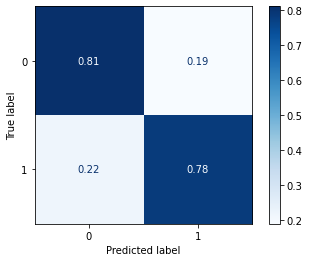

In [408]:
for model in resample_very_popular_clf_models:
    print(model)
    plot_confusion_matrix(model, X_test, very_popular_labels_test,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.show()

There is an improvement in the Gradient Boosted Classifier for predicting popular posts, though also a decrease in accuracy for predicting unpopular posts.

## Summary 

It is not trivial to predict number of upvotes for a reddit post given the features we selected. Nonetheless, some of those features clearly are informative about the number of upvotes.

Random Forests and Gradient Boosted algorithms seemed to performed best for this task (though admittedly there was a lot of parameter tweaking that could have been done that was not).

The exponential distribution of upvotes in our data meant that our training sample was severely imbalanced, with most of the samples having very few or no upvotes. Simple random undersampling fo the "unpopular" posts and oversampling of the "popular" posts helped with the imbalance.

# Next steps: 

- more sophisticated resampling
- try resampling for the regression
- analyze probability of assigning each class to see if certain posts were more uncertain
- analyze features to see which are most important
- tweak model parameters to improve performance
- combine classification with regression
- changing features
- 3 classes: very low, very high, and in between
